In [1]:
%load_ext autoreload
%autoreload 2

In [9]:
import sys
sys.path.append("..")

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from omegaconf import OmegaConf

from neuralbridge.run_scripts.read_config import read_config
from neuralbridge.stochastic_processes.examples import SDEFactory
from neuralbridge.solvers.sde import WienerProcess, Euler
from neuralbridge.models import neurb, pCN
from neuralbridge.utils.sample_path import SamplePath
from neuralbridge.utils.plotting import plot_landmark_sample_path
from neuralbridge.utils.t_grid import TimeGrid


### Visualizations of different processes

In [3]:
X_brownian_unc = SDEFactory(
    config=OmegaConf.create({
        "sde": {
            "name": "landmark",
            "n_landmarks": 50,
            "X_dim": 50 * 2,
            "W_dim": 50 * 2,
            "T": 1.0,
            "dt": 0.01,
            "t_scheme": "linear",
            "params_X_unc": {
                "k_alpha": 0.3,
                "k_sigma": 0.2,
                "n_landmarks": 50,
                "m_landmarks": 2
            }
        }
    })
).get_original_sde()

X_lagrangian_unc = SDEFactory(
    config=OmegaConf.create({
        "sde": {
            "name": "landmark",
            "n_landmarks": 50,
            "X_dim": 50 * 2,
            "W_dim": 50 * 2,
            "T": 1.0,
            "dt": 0.01,
            "t_scheme": "linear",
            "params_X_unc": {
                "k_alpha": 0.3,
                "k_sigma": 0.2,
                "n_landmarks": 50,
                "m_landmarks": 2
            }
        }
    })
).get_original_sde()

In [37]:
config = read_config("../configs/landmark_ellipse.yaml")
print(config)
u = jnp.array(config.sde.u)
v = jnp.array(config.sde.v)
u_closed = jnp.concatenate([u, u[:2]]).reshape(-1, 2)
v_closed = jnp.concatenate([v, v[:2]]).reshape(-1, 2)

{'sde': {'name': 'landmark', 'n_landmarks': 50, 'T': 1.0, 'dt': 0.01, 'X_dim': 100, 'W_dim': 100, 't_scheme': 'linear', 'params_X_unc': {'k_alpha': 0.3, 'k_sigma': 0.5, 'n_landmarks': 50, 'm_landmarks': 2}, 'params_X_aux': {'k_alpha': 0.3, 'k_sigma': 0.5, 'n_landmarks': 50, 'm_landmarks': 2}, 'u': [0.0, 0.5, 0.12533323356430426, 0.49605735065723894, 0.2486898871648548, 0.48429158056431554, 0.368124552684678, 0.4648882429441257, 0.4817536741017153, 0.4381533400219318, 0.5877852522924731, 0.4045084971874737, 0.6845471059286887, 0.3644843137107058, 0.7705132427757893, 0.3187119948743448, 0.8443279255020151, 0.2679133974894983, 0.9048270524660196, 0.21288964578253633, 0.9510565162951535, 0.15450849718747373, 0.9822872507286887, 0.09369065729286226, 0.9980267284282716, 0.03139525976465665, 0.9980267284282716, -0.0313952597646567, 0.9822872507286886, -0.09369065729286241, 0.9510565162951535, -0.15450849718747378, 0.9048270524660195, -0.21288964578253636, 0.844327925502015, -0.267913397489498

In [5]:
X_brownian_unc.initialize_g(u)

unconditional process plotting

In [7]:
tGrid = TimeGrid(
    T=config.sde.T,
    dt=config.sde.dt,
    t_scheme=config.sde.t_scheme
)
W = WienerProcess(
    config.sde.W_dim
)

In [24]:
X_brownian_unc_solver = Euler(X_brownian_unc, W, tGrid)
X_brownian_unc_path = X_brownian_unc_solver.solve(x0=u, batch_size=4, rng_key=jax.random.PRNGKey(0))
X_lagrangian_unc_solver = Euler(X_lagrangian_unc, W, tGrid)
X_lagrangian_unc_path = X_lagrangian_unc_solver.solve(x0=u, batch_size=4, rng_key=jax.random.PRNGKey(0))

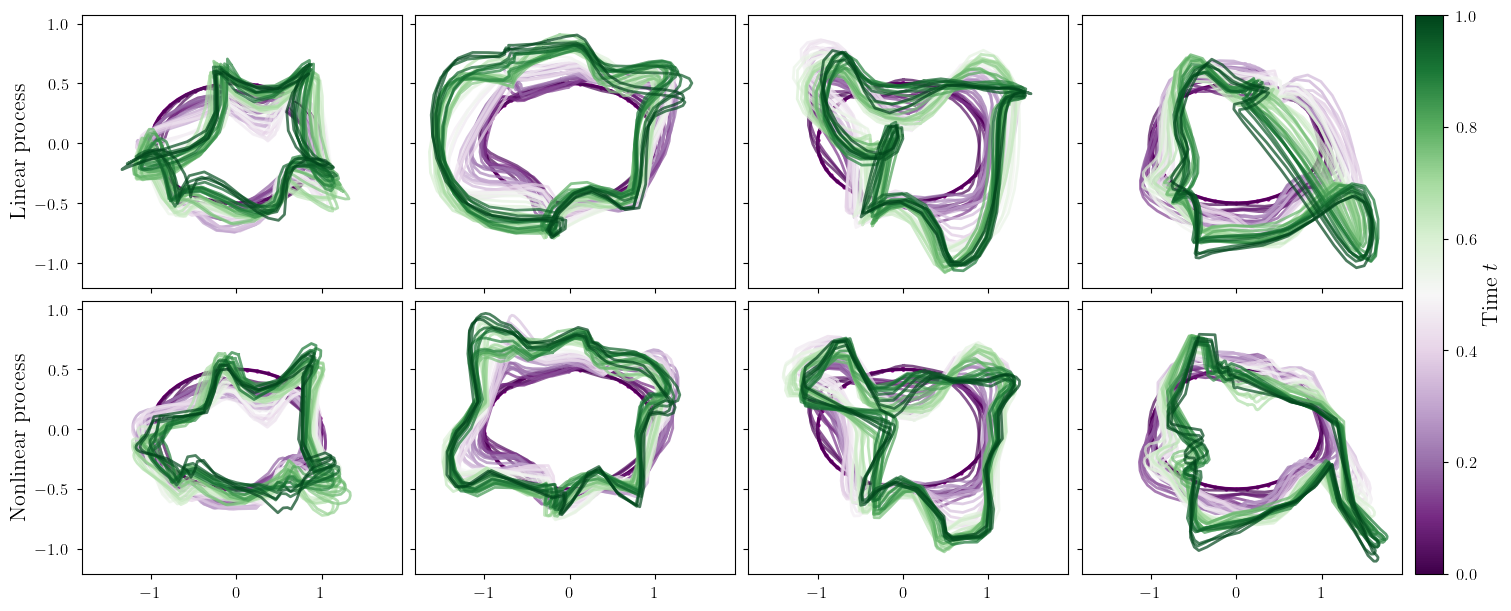

In [27]:
fig, axes = plt.subplots(2, 4, figsize=(15, 6), sharey=True, sharex=True, layout="constrained")
axes[0, 0].set_ylabel(r'Linear process', fontsize=16)
axes[1, 0].set_ylabel(r'Nonlinear process', fontsize=16)

for i, ax in enumerate(axes[0]):
    ax.plot(*u_closed.T, '-o', color="purple", alpha=1.0, linewidth=2.5, markersize=3, label=r'$u$')
    ax, mappable = plot_landmark_sample_path(
        X_brownian_unc_path[i],
        ax=ax,
        m_landmarks=2,
        cmap="PRGn",
        show_intermediate_shapes=True,
        show_intermediate_trajectories=False,
        markersize=10,
        alpha=0.7,
        show_every=2,
        linewidth=2.0,
        show_colorbar=False
    )
    ax.tick_params(axis='both', which='major', labelsize=12)
    
for i, ax in enumerate(axes[1]):
    ax.plot(*u_closed.T, '-o', color="purple", alpha=1.0, linewidth=2.5, markersize=3, label=r'$u$')
    ax, mappable = plot_landmark_sample_path(
        X_lagrangian_unc_path[i],
        ax=ax,
        m_landmarks=2,
        cmap="PRGn",
        show_intermediate_shapes=True,
        show_intermediate_trajectories=False,
        markersize=10,
        alpha=0.7,
        show_every=2,
        linewidth=2.0,
        show_colorbar=False
    )
    ax.tick_params(axis='both', which='major', labelsize=12)

cbar = fig.colorbar(mappable, ax=axes.ravel().tolist(), label=r'Time $t$', pad=0.01)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(r'Time $t$', fontsize=16)
fig.savefig("../assets/figures/landmark_model/ellipse_unconditional_samples.pdf", dpi=300, bbox_inches="tight")

#### Neural bridge

In [38]:
neural_bridge_model = neurb.NeuralBridge(config)
_ = neural_bridge_model.train(mode="pretrained", load_relative_dir="../assets/ckpts/neurb")
X_neu = neural_bridge_model.build_neural_bridge()

X_neu_solver = Euler(X_neu, W, tGrid)
X_neu_path = X_neu_solver.solve(x0=u, batch_size=16)

/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/lib/python3.11/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1136: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(
INFO:root:Checkpoint loaded from /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neurb/landmark_ellipse_50_tanh_linear_None_norm_0.0_dropout_adam_opt


#### Pre-conditioned Crank-Nicolson

In [40]:
config = read_config("../configs/landmark_ellipse.yaml")


pcn_model = pCN.PreconditionedCrankNicolson(
    X=neural_bridge_model.X_gui,
    config=config
)
pcn_logs, _ = pcn_model.run(log_every=500)
X_pcn_path = SamplePath(
    xs = jnp.concatenate([pcn_logs[i].path.xs for i in range(len(pcn_logs))]),
    ts = pcn_logs[0].path.ts
)

Running pCN with log every 500: 100%|██████████| 5000/5000 [01:29<00:00, 55.80it/s]
INFO:root:Batch average acceptance rate: 12.62%


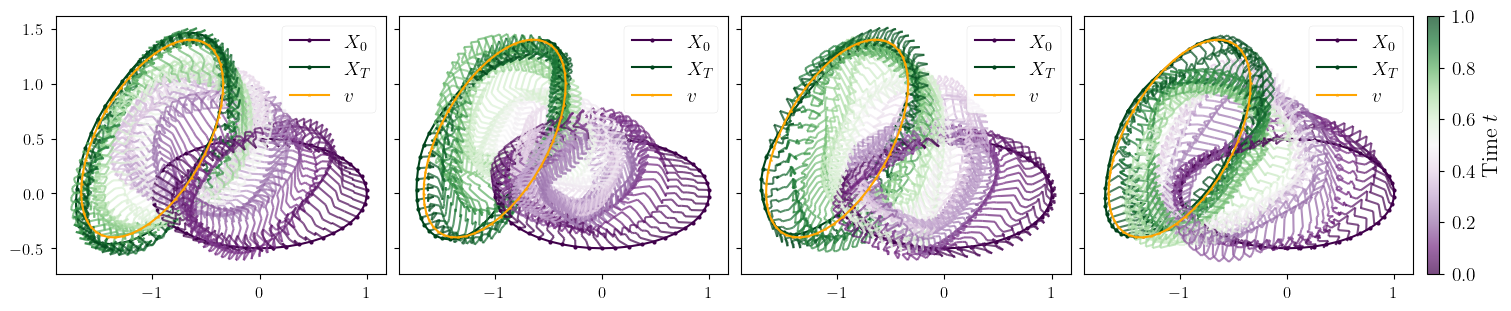

In [39]:
fig, axes = plt.subplots(1, 4, figsize=(15, 3), sharey=True, sharex=True, layout="constrained")

for i, ax in enumerate(axes):
    _, mappable = plot_landmark_sample_path(
        X_neu_path[i+4],
        ax=ax,
        m_landmarks=2,
        cmap="PRGn",
        show_intermediate_trajectories=True,
        show_intermediate_shapes=False,
        markersize=3,
        alpha=0.7,
        show_every=1,
        linewidth=1.5,
        show_colorbar=False
    )
    ax.plot(*v_closed.T, '-*', color="orange", alpha=1.0, linewidth=1.5, markersize=3, label=r'$v$')
    ax.legend(fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)

cbar = fig.colorbar(mappable, ax=axes.ravel().tolist(), label=r'Time $t$', pad=0.01)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(r'Time $t$', fontsize=16)
fig.savefig("../assets/figures/landmark_model/ellipse_neural_bridge_samples.pdf", dpi=300, bbox_inches="tight")

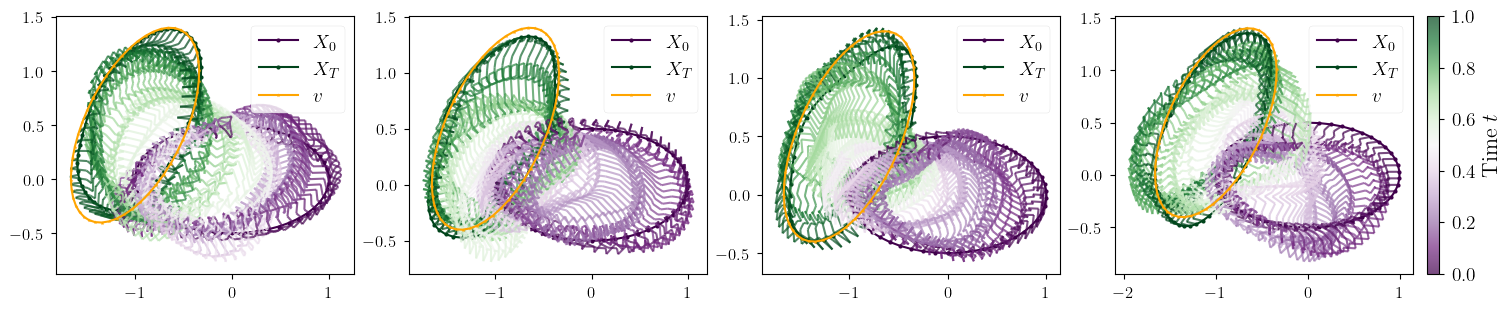

In [42]:
fig, axes = plt.subplots(1, 4, figsize=(15, 3), layout="constrained")

for i, ax in enumerate(axes):
    _, mappable = plot_landmark_sample_path(
        X_pcn_path[i],
        ax=ax,
        m_landmarks=2,
        cmap="PRGn",
        show_intermediate_trajectories=True,
        show_intermediate_shapes=False,
        markersize=3,
        alpha=0.7,
        show_every=1,
        linewidth=1.5,
        show_colorbar=False
    )
    ax.plot(*v_closed.T, '-*', color="orange", alpha=1.0, linewidth=1.5, markersize=3, label=r'$v$')
    ax.legend(fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)

cbar = fig.colorbar(mappable, ax=axes.ravel().tolist(), label=r'Time $t$', pad=0.01)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(r'Time $t$', fontsize=16)
fig.savefig("../assets/figures/landmark_model/ellipse_pcn_samples.pdf", dpi=300, bbox_inches="tight")